In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from pandas_profiling import ProfileReport
import sqlalchemy as sa

# Local libraries
import pudl

In [4]:
pudl_settings = pudl.workspace.setup.get_defaults()
display(pudl_settings)

pudl_engine = sa.create_engine(pudl_settings['pudl_db'])
display(pudl_engine)

{'pudl_in': '/home/tpb/catalyst/workspace',
 'data_dir': '/home/tpb/catalyst/workspace/data',
 'settings_dir': '/home/tpb/catalyst/workspace/settings',
 'pudl_out': '/home/tpb/catalyst/workspace',
 'sqlite_dir': '/home/tpb/catalyst/workspace/sqlite',
 'parquet_dir': '/home/tpb/catalyst/workspace/parquet',
 'ferc1_db': 'sqlite:////home/tpb/catalyst/workspace/sqlite/ferc1.sqlite',
 'pudl_db': 'sqlite:////home/tpb/catalyst/workspace/sqlite/pudl.sqlite',
 'censusdp1tract_db': 'sqlite:////home/tpb/catalyst/workspace/sqlite/censusdp1tract.sqlite'}

Engine(sqlite:////home/tpb/catalyst/workspace/sqlite/pudl.sqlite)

In [5]:
pudl_out = pudl.output.pudltabl.PudlTabl(
    freq=None,
    start_date=None,
    end_date=None,
    pudl_engine=pudl_engine,
    fill_fuel_cost=False,  # do it manually to preserve all values
)

In [8]:
frc = pudl.analysis.fuel_price.load_pudl_features(pudl_engine)

In [ ]:
categorical_types = frc.select_dtypes('object').nunique() < 2**8

In [18]:
categorical_cols = list(categorical_types[categorical_types].index)
categorical_cols

['contract_type_code',
 'energy_source_code',
 'fuel_type_code_pudl',
 'primary_transportation_mode_code',
 'secondary_transportation_mode_code',
 'natural_gas_transport_code',
 'natural_gas_delivery_contract_type_code',
 'mine_type_code',
 'mine_county_id_fips',
 'mine_state',
 'fuel_group_eiaepm',
 'iso_rto_code',
 'state',
 'sector_name_eia',
 'natural_gas_pipeline_name_2',
 'natural_gas_pipeline_name_3',
 'regulatory_status_code']

In [ ]:
frc.loc[:, categorical_cols] = frc.loc[:, categorical_cols].astype('category')

In [21]:
frc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 571400 entries, 0 to 571399
Data columns (total 39 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   report_date                              571400 non-null  datetime64[ns]
 1   plant_id_eia                             571400 non-null  int64         
 2   contract_type_code                       571162 non-null  category      
 3   contract_expiration_date                 248824 non-null  object        
 4   energy_source_code                       571399 non-null  category      
 5   fuel_type_code_pudl                      571399 non-null  category      
 6   mine_id_pudl                             208764 non-null  float64       
 7   supplier_name                            571397 non-null  object        
 8   fuel_received_units                      571400 non-null  float64       
 9   fuel_mmbtu_per_unit       

## Missingness

## Plant-wise

In [50]:
plant_nulls = frc.set_index('plant_id_eia').isna().groupby('plant_id_eia').mean()

<AxesSubplot:>

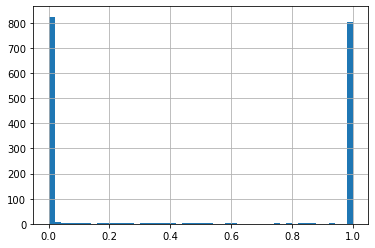

In [52]:
# plants mostly either have all their price data or they have none of it. Not much between
plant_nulls['fuel_cost_per_mmbtu'].hist(bins=50)

In [63]:
binned_plant_nulls = pd.cut(plant_nulls['fuel_cost_per_mmbtu'], bins=[-np.inf, 0, 1-1e-6, 1], right=True, labels=['all prices', 'mixed', 'no prices'])
binned_plant_nulls.value_counts()

all prices    806
no prices     801
mixed         119
Name: fuel_cost_per_mmbtu, dtype: int64

In [64]:
# same as above but as fraction
binned_plant_nulls.value_counts(normalize=True)

all prices    0.466976
no prices     0.464079
mixed         0.068946
Name: fuel_cost_per_mmbtu, dtype: float64

In [67]:
frc = frc.merge(binned_plant_nulls.rename('null_category'), on='plant_id_eia', how='left')

In [70]:
# what fraction of rows belong to plants with no price info?
frc.groupby('null_category').size() / frc.shape[0]

null_category
all prices    0.605016
mixed         0.091901
no prices     0.303084
dtype: float64

In [72]:
list(frc.columns)

['report_date',
 'plant_id_eia',
 'contract_type_code',
 'contract_expiration_date',
 'energy_source_code',
 'fuel_type_code_pudl',
 'mine_id_pudl',
 'supplier_name',
 'fuel_received_units',
 'fuel_mmbtu_per_unit',
 'sulfur_content_pct',
 'ash_content_pct',
 'mercury_content_ppm',
 'fuel_cost_per_mmbtu',
 'primary_transportation_mode_code',
 'secondary_transportation_mode_code',
 'natural_gas_transport_code',
 'natural_gas_delivery_contract_type_code',
 'moisture_content_pct',
 'chlorine_content_ppm',
 'mine_name',
 'mine_type_code',
 'mine_county_id_fips',
 'mine_state',
 'fuel_group_eiaepm',
 'ferc_cogen_status',
 'ferc_exempt_wholesale_generator',
 'ferc_small_power_producer',
 'iso_rto_code',
 'latitude',
 'longitude',
 'state',
 'county',
 'sector_name_eia',
 'natural_gas_pipeline_name_1',
 'natural_gas_pipeline_name_2',
 'natural_gas_pipeline_name_3',
 'regulatory_status_code',
 'water_source',
 'null_category']

In [73]:
plant_cols = [
    'ferc_cogen_status',
     'ferc_exempt_wholesale_generator',
     'ferc_small_power_producer',
     'iso_rto_code',
     'latitude',
     'longitude',
     'state',
     'county',
     'sector_name_eia',    
]

In [75]:
plants = frc.groupby('plant_id_eia')[plant_cols].nth(0).join(binned_plant_nulls.rename('null_category'))

In [76]:
plants.to_csv('plant_nulls.csv', index=True)

<AxesSubplot:>

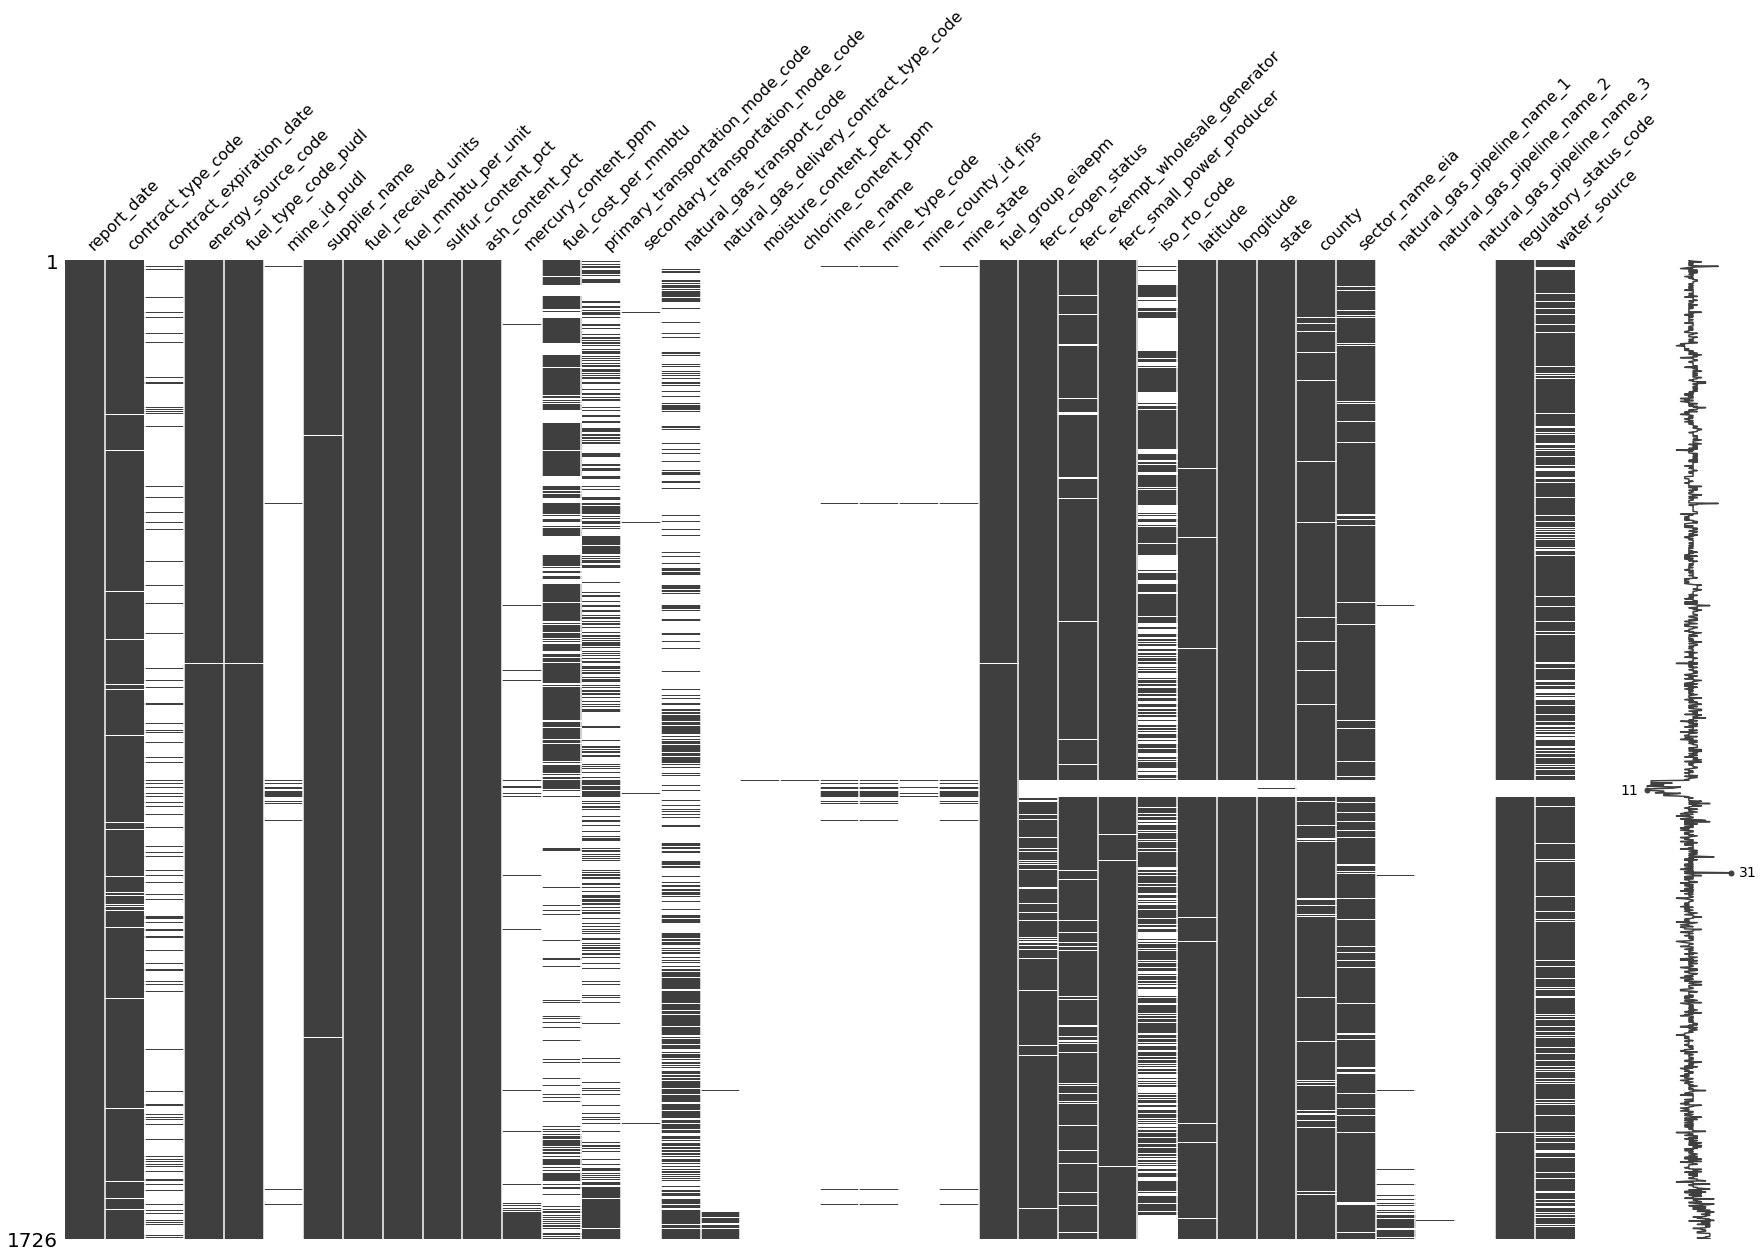

In [51]:
msno.matrix(plant_nulls.where(plant_nulls == 0), figsize=(30,18))

In [39]:
plant_month_nulls = frc.set_index(['plant_id_eia', 'report_date']).isna().groupby(['plant_id_eia', 'report_date']).mean()

In [43]:
plant_month_nulls

contract_type_code  contract_expiration_date  energy_source_code  fuel_type_code_pudl  mine_id_pudl  supplier_name  fuel_received_units  fuel_mmbtu_per_unit  sulfur_content_pct  ash_content_pct  mercury_content_ppm  fuel_cost_per_mmbtu  primary_transportation_mode_code  secondary_transportation_mode_code  natural_gas_transport_code  natural_gas_delivery_contract_type_code  moisture_content_pct  chlorine_content_ppm  mine_name  mine_type_code  mine_county_id_fips  mine_state  fuel_group_eiaepm  ferc_cogen_status  ferc_exempt_wholesale_generator  ferc_small_power_producer  iso_rto_code  latitude  longitude  state  county  sector_name_eia  natural_gas_pipeline_name_1  natural_gas_pipeline_name_2  natural_gas_pipeline_name_3  regulatory_status_code  water_source
plant_id_eia report_date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
3            2008-01-01                  0.0                  0.333333                 0.0                  0.0      0.333333            0.0                  0.0                  0.0                 0.0              0.0                  1.0                  0.0                               0.0                                 1.0                         0.0                                      1.0                   1.0                   1.0   0.333333        0.333333                  1.0    0.333333                0.0                0.0                              0.0                        0.0           1.0       0.0        0.0    0.0     0.0              0.0                          1.0                          1.0                          1.0                     0.0           0.0
             2008-02-01                  0.0                  0.500000                 0.0                  0.0      0.500000            0.0                  0.0                  0.0                 0.0              0.0                  1.0                  0.0                               0.0                                 1.0                         0.0                                      1.0                   1.0                   1.0   0.500000        0.500000                  1.0    0.500000                0.0                0.0                              0.0                        0.0           1.0       0.0        0.0    0.0     0.0              0.0                          1.0                          1.0                          1.0                     0.0           0.0
             2008-03-01                  0.0                  0.333333                 0.0                  0.0      0.333333            0.0                  0.0                  0.0                 0.0              0.0                  1.0                  0.0                               0.0                                 1.0                         0.0                                      1.0                   1.0                   1.0   0.333333        0.333333                  1.0    0.333333                0.0                0.0                              0.0                        0.0           1.0       0.0        0.0    0.0     0.0              0.0                          1.0                          1.0                          1.0                     0.0           0.0
             2008-04-01                  0.0       

<AxesSubplot:>

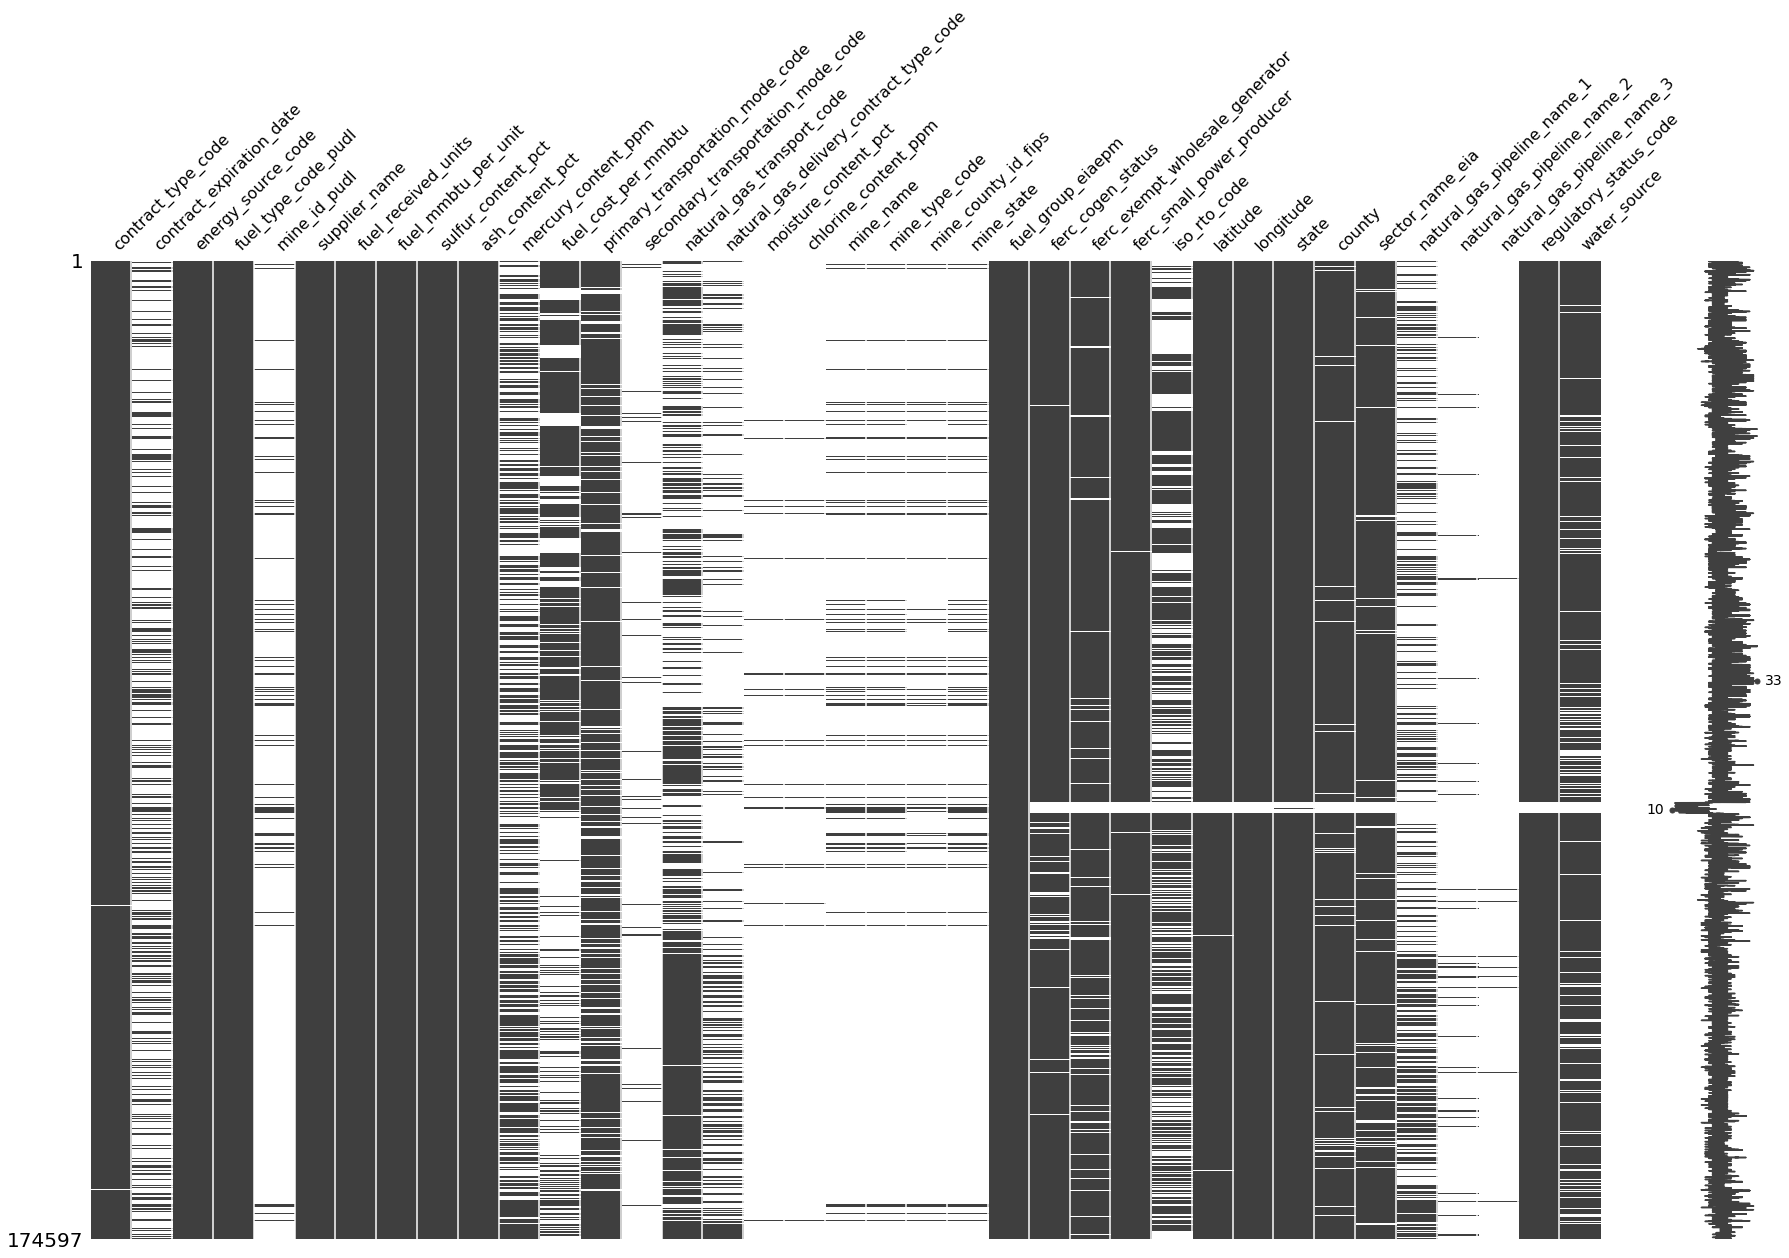

In [49]:
msno.matrix(plant_month_nulls.where(plant_month_nulls == 0), figsize=(30,18))

<AxesSubplot:>

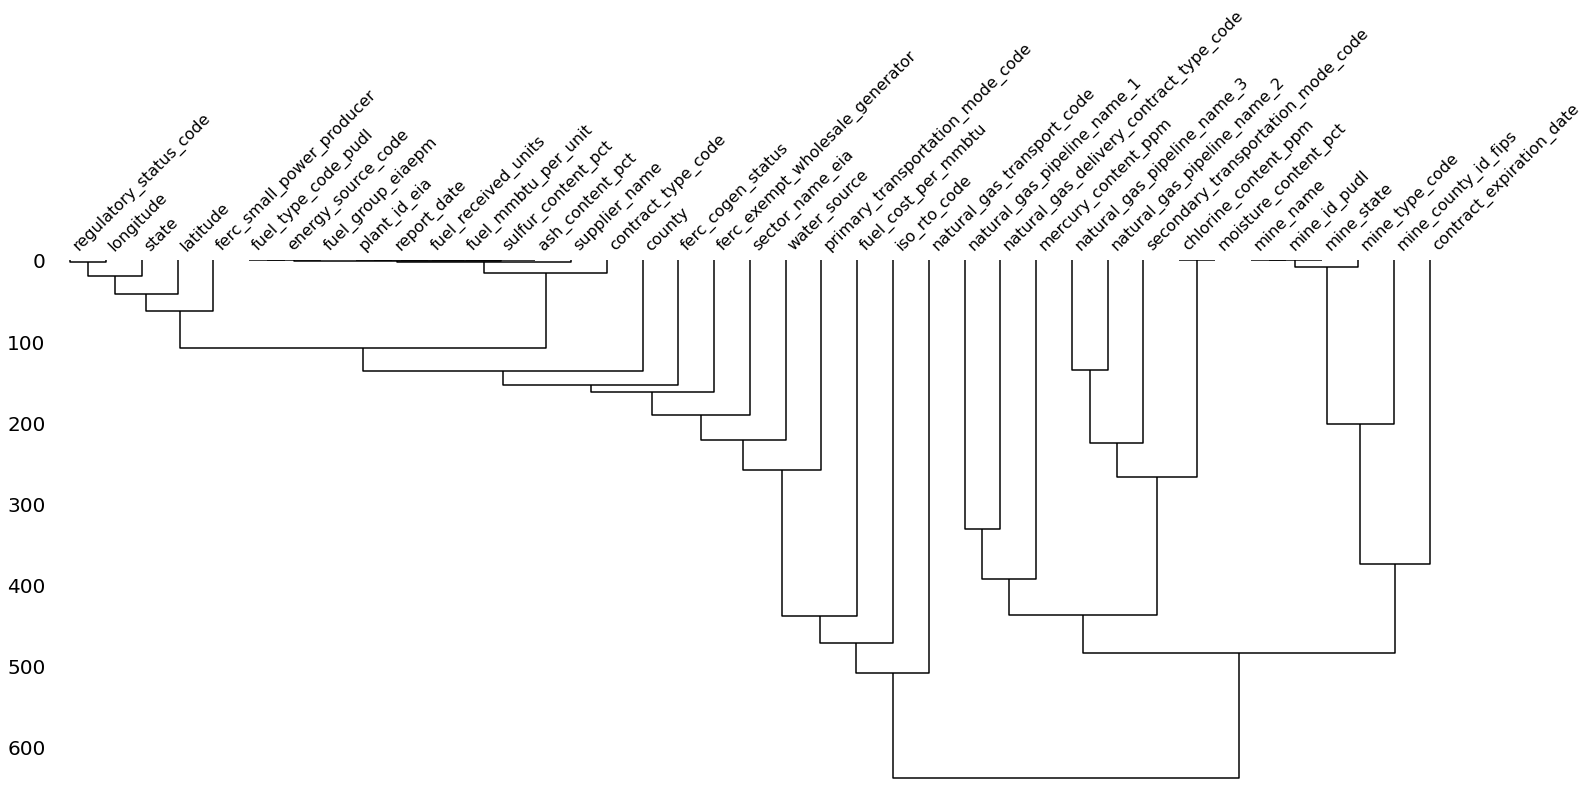

In [24]:
msno.dendrogram(frc, method='average')

<AxesSubplot:>

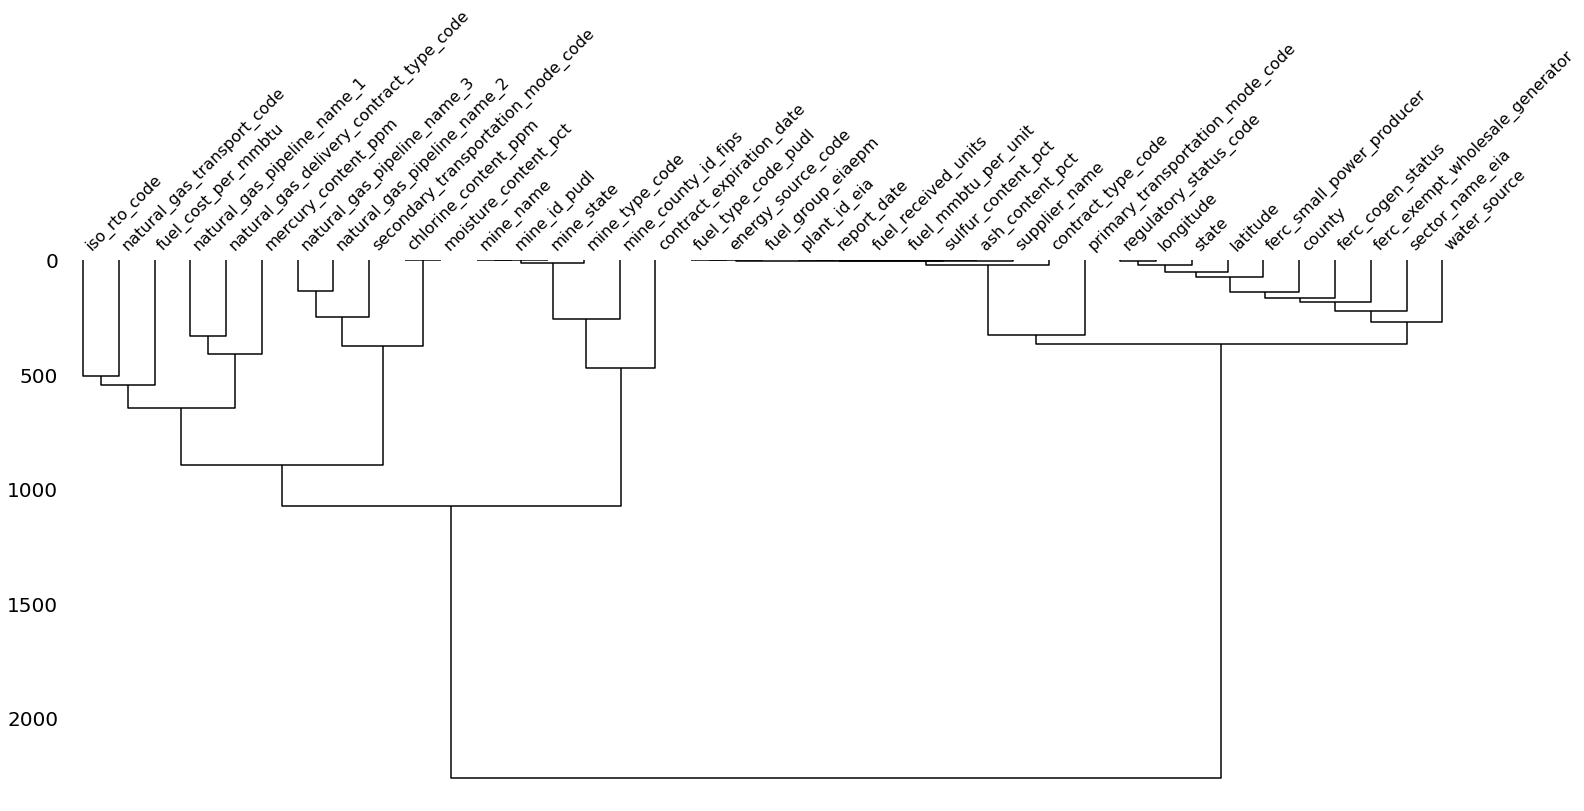

In [32]:
msno.dendrogram(frc, method='ward')